In [1]:
import sys
import pandas as pd
from collections import Counter
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
# tai from ... import *

# Dataframe haku widgeteillä

In [2]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-05-01'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
        user="root",
        port=3306,
        passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

# Kun haku on valmis niin dataframe tallenttuu df:ään

In [30]:
df.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.530,2762,-257,37,15,787
1,1,2020-06-24 15:20:08.620,2870,-344,38,14,738
2,1,2020-06-24 15:20:09.620,2916,-344,38,14,738
3,1,2020-06-24 15:20:09.620,2894,-254,38,15,788
4,1,2020-06-24 15:20:10.110,2888,-188,38,16,838


# Dataframe suodattaminen widgeteillä

In [31]:
#display(start_date, end_date, tunnit)
display(tunnit)

SelectionRangeSlider(description='Tunnit', index=(0, 14), options=(8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

In [32]:
# Kutstutaan sort_by_widgets ja boom dataframessa on ainoastaan 11-19 tunnit
df1 = sort_by_widgets(df)
df1.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.530,2762,-257,37,15,787
1,1,2020-06-24 15:20:08.620,2870,-344,38,14,738
2,1,2020-06-24 15:20:09.620,2916,-344,38,14,738
3,1,2020-06-24 15:20:09.620,2894,-254,38,15,788
4,1,2020-06-24 15:20:10.110,2888,-188,38,16,838


# Katsotaan kuinka paljon kutakin nodea on käytetty

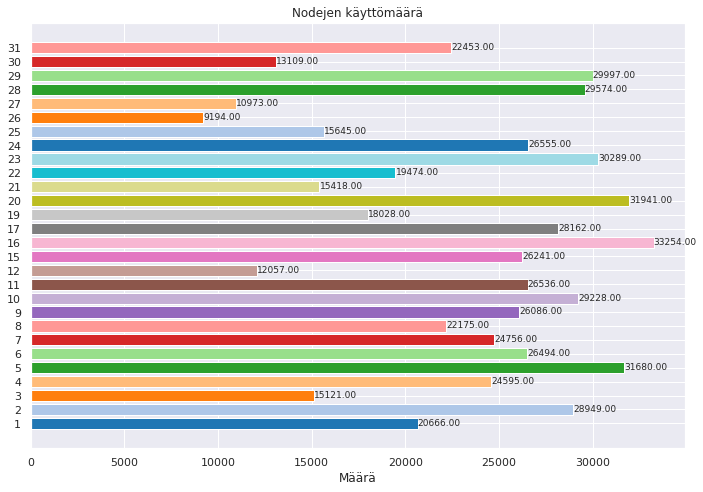

In [33]:
draw_node_amount(df1, 'node_id')

# 40x40 Gridi datasta

In [34]:
grid_size = 40
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.530,2762,-257,29,11,469
1,1,2020-06-24 15:20:08.620,2870,-344,30,11,470
2,1,2020-06-24 15:20:09.620,2916,-344,30,11,470
3,1,2020-06-24 15:20:09.620,2894,-254,30,11,470
4,1,2020-06-24 15:20:10.110,2888,-188,30,12,510


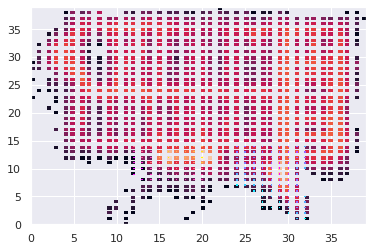

In [35]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

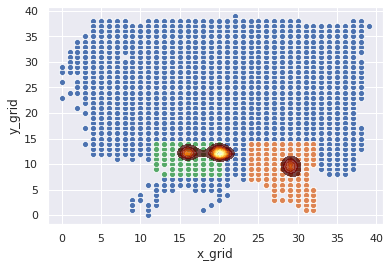

In [36]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()

### Erotetaan kauppareissut toisistaan

In [37]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)

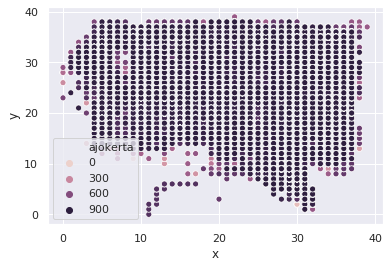

In [38]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

In [39]:
aloitukset, lapimenoajat = get_lapimeno(reitit, grid_size)

In [40]:
df2 = pd.DataFrame(list(zip(aloitukset,lapimenoajat)), columns =['Aloitus', 'Kesto'])
df2['h'] = df2['Aloitus'].dt.strftime('%H').astype('float')
df2.head()

,Aloitus,Kesto,h
0,2020-06-24 15:20:08.620,17:59:49.610000,15.0
1,2020-06-25 12:25:05.350,00:04:28,12.0
2,2020-06-25 13:39:58.630,01:53:54.010000,13.0
3,2020-06-25 15:58:15.570,00:18:43.070000,15.0
4,2020-06-25 17:07:41.640,00:22:12,17.0


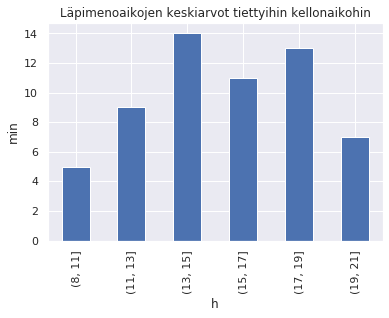

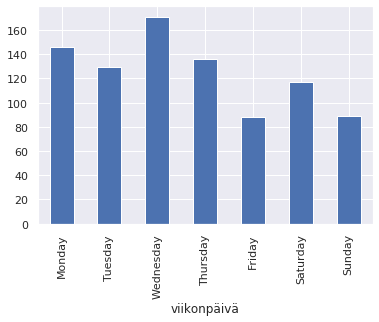

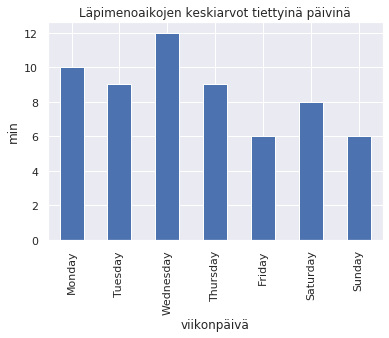

In [41]:
df2_aika = [8, 11, 13, 15, 17, 19, 21]
df2_ajat = pd.cut(df2['h'], df2_aika)  #Tehdään ajat bin johon tallennetaan tunnit ja näin HUOM! pitäisi pystyä laittamaan läpimenoajat eri tunti-ikkunoitten sisään
keskiarvot = (df2.groupby (df2_ajat)["Kesto"].count() / len(df2['Kesto'])) * 60 #Lasketaan keskiarvot aikaikkunoitten sisällä sekä muutetaan saadut luvut minuuteiksi
keskiarvot=(round(keskiarvot)) #Pyöristetään saadut luvut


plot_df_keskiarvo = (keskiarvot)
plt.ylabel("min")
plt.title("Läpimenoaikojen keskiarvot tiettyihin kellonaikohin")
plot_df_keskiarvo.plot(kind = 'bar')
plt.show()


df2['viikonpäivä'] = df2['Aloitus'].apply(lambda x: x.weekday())
df2['viikonpäivä'] = df2['Aloitus'].dt.day_name()
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df2['viikonpäivä'] = pd.Categorical(df2['viikonpäivä'], categories=sorter, ordered=True)
df2 = df2.sort_values('viikonpäivä')

päivät = df2['viikonpäivä']
#df2_päivät = pd.cut(df2["h"], päivät)
plot_viikonpäivä = df2.groupby(päivät)["Kesto"].count()
plt.title("")
plot_viikonpäivä.plot(kind = 'bar')
plt.show()


keskiarvot_pv = (df2.groupby (päivät)["Kesto"].count() / len(df2['Kesto'])) * 60
keskiarvot_pv=(round(keskiarvot_pv))

plot_df_keskiarvo_pv = (keskiarvot_pv)
plt.ylabel("min")
plt.title("Läpimenoaikojen keskiarvot tiettyinä päivinä")
plot_df_keskiarvo_pv.plot(kind = 'bar')
plt.show()

# Horrostilat dataframeen

In [6]:
df = horrostila(df)
df.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id,Horrostila
0,1,2020-08-19 08:21:14.910,2572,-752,35,10,535,False
1,1,2020-08-19 08:57:15.910,2597,-828,35,10,535,True
2,1,2020-08-19 09:24:58.910,2660,-1005,36,8,436,True
3,1,2020-08-19 09:33:14.910,2671,-925,36,9,486,True
4,1,2020-08-19 09:49:01.910,2669,-954,36,9,486,True
